# Computer Problem Set 3.1 : Monte-Carlo approximation of the Greeks

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from scipy.special import erf

In the context of the Black-Scholes model with constant interest rate $r$, constant volatility parameter $\sigma >0$, and Brownian motion $B$ under the risk-neutral measure :
$$ dS_t := S_t (r dt + \sigma dB_t) $$
we are interested in the numerical approximation of the npo-arbitrage price of a binary option defined by the payoff $\mathbb{1}_{S_T\leq K}$ at the maturity date $T$, for some $K>0$, together with the corresponding optimal hedging strategy :

$$ C_0 := e^{-rT} \mathbb{E}[\mathbb{1}_{S_T\leq K}]$$
$$\Delta_0 := e^{-rT} \frac{\partial}{\partial S_0} \mathbb{E}[\mathbb{1}_{S_T\leq K}]$$

In terms of the cdf of the $N(0,1)$ distribution, direct calculation leads to :

$$ C_0 := e^{-rT} N(-d_{-}(X_0, \sigma^2 T)) $$
$$\delta_0 := \frac{-e^{-rT}}{S_0 \sqrt{\sigma^2 T}} N'(-d_{-}(X_0, \sigma^2 T))$$

with $X_0 := \frac{S_0}{K e^{-rT}}$ and $d_{-}(x,v) := \frac{\ln{x}}{\sqrt{v}} - \frac{1}{2} \sqrt{v}$.


### Question 1 : Monte Carlo approximation of $C_0$

In [18]:
r=0.02
sigma=0.4
K=80
T=0.9
S0=100

K_values=np.array(np.arange(80,121))

n=100
M=1000

In [19]:
def brownian_motion(n,m):
    dT=T/n
    Z=np.random.randn(m, n)*np.sqrt(dT)
    
    return np.concatenate((np.zeros([m,1]) , np.cumsum(Z, axis=1)), axis=1)

def geometric_brownian(n=n, m=M, S0=S0, mu=r, sigma=sigma):
    W=brownian_motion(n,m)
    dT=T/n
    return S0*np.exp((mu-0.5*sigma**2)*np.arange(0,n+1)*dT + sigma*W)
    
#let's define phi as the cdf of the normal distribution
def phi(x):
    return (1.0+erf(x/np.sqrt(2)))/2.0

#and its derivative
def phip(x):
    return np.exp(-0.5*x**2)/np.sqrt(2*np.pi)

In [20]:
def c_and_delta(k=K):
    x0=S0/(k*np.exp(-r*T))
    d=np.log(x0)/np.sqrt(T*sigma**2)-0.5*np.sqrt(T*sigma**2)
    return np.exp(-r*T)*phi(-d), -np.exp(-r*T)* phip(-d) / (S0*np.sqrt(T*sigma**2))

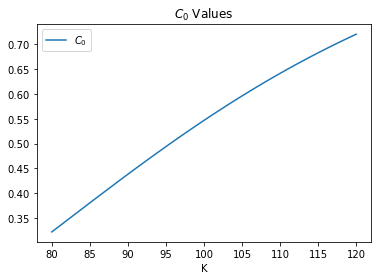

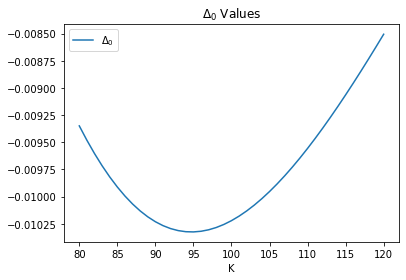

In [21]:
c,d=c_and_delta(K_values)
plt.plot(K_values,c, label="$C_0$")
plt.title("$C_0$ Values")
plt.xlabel("K")
plt.legend()
plt.figure()
plt.plot(K_values, d, label="$\Delta_0$")
plt.title("$\Delta_0$ Values")
plt.xlabel("K")
plt.legend()
plt.show()

In [22]:
def C_monte_carlo(k,s=S0,n=n,m=M):
    ST=geometric_brownian(n,m,s)[:,-1]
    res=np.exp(-r*T)*((k-ST)>=0)
    return np.mean(res),np.std(res)

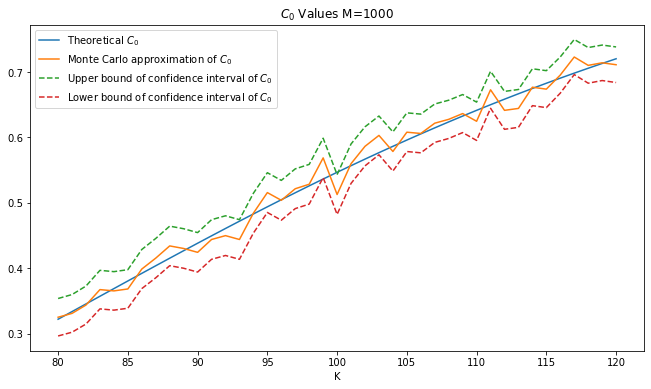

In [23]:
alpha = 0.05
q = sps.norm.ppf(1-alpha/2, loc=0, scale=1)

C=[C_monte_carlo(k) for k in K_values]
CIU=np.transpose(C)[0]+q*np.transpose(C)[1]/np.sqrt(M)
CIL=np.transpose(C)[0]-q*np.transpose(C)[1]/np.sqrt(M)
C=np.transpose(C)[0]

plt.figure(figsize=(11,6))
plt.plot(K_values,c, label="Theoretical $C_0$")
plt.plot(K_values,C, label="Monte Carlo approximation of $C_0$")
plt.plot(K_values,CIU,'--', label="Upper bound of confidence interval of $C_0$")
plt.plot(K_values,CIL,'--', label="Lower bound of confidence interval of $C_0$")
plt.title("$C_0$ Values M=1000")
plt.xlabel("K")
plt.legend()
plt.show()

### Question 2

In [24]:
def CI_delta(k,epsilon,s=S0,n=n,m=M):
    m1,s1=C_monte_carlo(k,s+epsilon,n,m)
    m2,s2=C_monte_carlo(k,s-epsilon,n,m)
    return ((m1-m2)/(2*epsilon)), np.sqrt((s1**2+s2**2)/(4*epsilon**2))

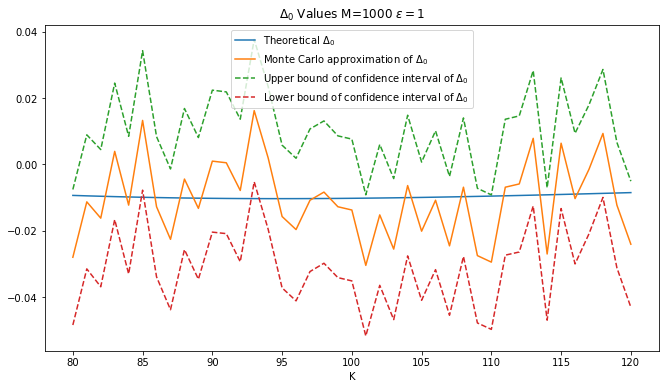

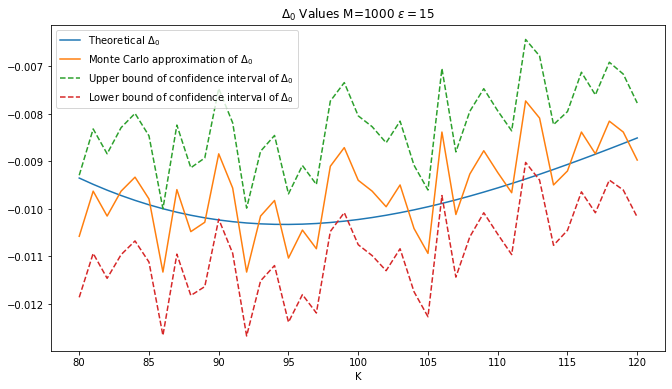

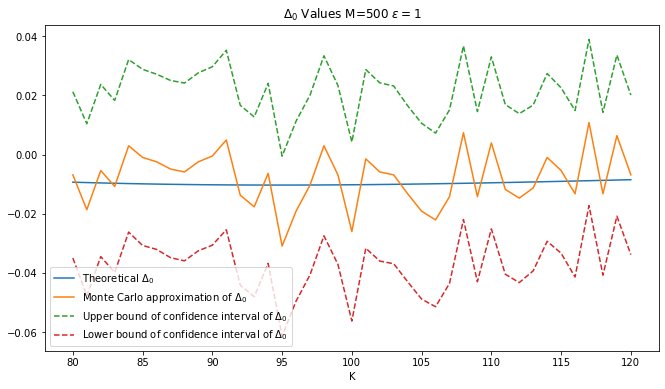

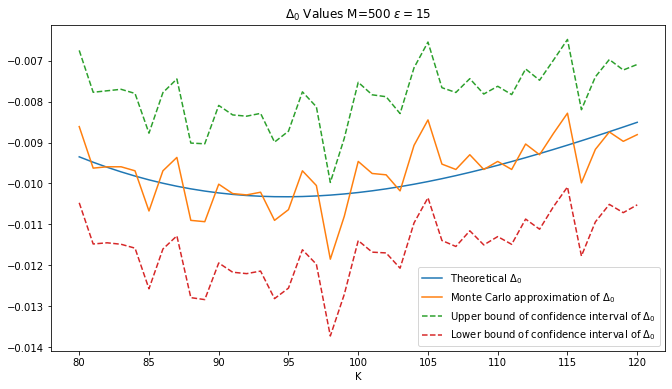

In [28]:
def plot_Delta(M,epsilon):
    
    D_approx=[CI_delta(k,epsilon,n,M) for k in K_values]
    CIUd=np.transpose(D_approx)[0]+q*np.transpose(D_approx)[1]/np.sqrt(M)
    CILd=np.transpose(D_approx)[0]-q*np.transpose(D_approx)[1]/np.sqrt(M)
    D_approx=np.transpose(D_approx)[0]

    plt.figure(figsize=(11,6))
    plt.plot(K_values,d, label="Theoretical $\Delta_0$")
    plt.plot(K_values,D_approx, label="Monte Carlo approximation of $\Delta_0$")
    plt.plot(K_values,CIUd,'--', label="Upper bound of confidence interval of $\Delta_0$")
    plt.plot(K_values,CILd,'--', label="Lower bound of confidence interval of $\Delta_0$")
    plt.title("$\Delta_0$ Values M="+str(M)+" $\epsilon= $"+str(epsilon))
    plt.xlabel("K")
    plt.legend()



plot_Delta(1000,1)
plot_Delta(1000,15)
plot_Delta(500,1)
plot_Delta(500,15)
plt.show()



The approximation has an overall big variance. Large values of M tend to yield a better result.
Small values of $\epsilon$ tend not to give the best results. Here for example a value of 15 gives a better approximation than a value of 1.

### Question 3

We have the following expression for $\Delta_0$ :
$$ \Delta_0 = e^{-rT} \mathbb{E}[\mathbb{1}_{S_T\leq K} \frac{B_T}{S_0 \sigma T}] $$

In [31]:
#This function returns the values at maturity T of St and the Brownian motion used to generate it Bt
def BT_ST(n=n,m=M,S0=S0, mu=r, sigma=sigma):
    W=brownian_motion(n,m)
    dT=T/n
    return S0*np.exp((mu-0.5*sigma**2)*np.arange(0,n+1)*dT + sigma*W)[:,-1], W[:,-1]

def D_monte_carlo(k,s=S0,n=n,m=M):
    ST,BT=BT_ST(n,m,s)
    return np.mean(((k-ST)>=0)*BT)*np.exp(-r*T)/(sigma*T*S0)
    

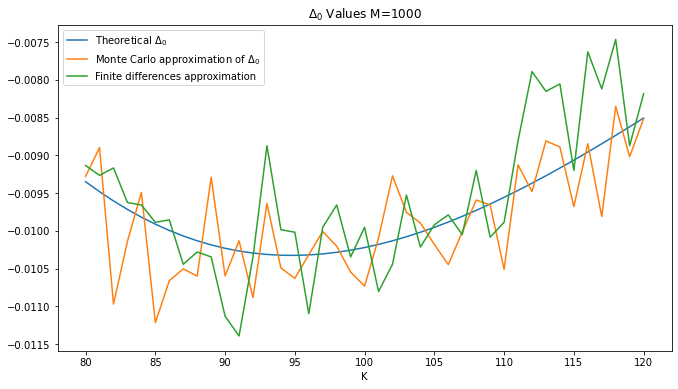

In [33]:
D=[D_monte_carlo(k) for k in K_values]
plt.figure(figsize=(11,6))
plt.plot(K_values,d, label="Theoretical $\Delta_0$")
plt.plot(K_values,D, label="Monte Carlo approximation of $\Delta_0$")

D_approx=[CI_delta(k,15,n,M) for k in K_values]
D_approx=np.transpose(D_approx)[0]
plt.plot(K_values, D_approx, label="Finite differences approximation")
plt.title("$\Delta_0$ Values M=1000")
plt.xlabel("K")
plt.legend()
plt.show()

We can conclude that the latter approach gives better results than the finite differences approximation used in question 2. This can be explained by the fact that the latter approach uses more information concerning the expression of $\Delta_0$ and therefore yields a results which has a smaller variance than the previous method.